# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [3]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [4]:
# env = gym.make('CartPole-v0')
# env.seed(0)
# print('observation space:', env.observation_space)
# print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self,
                 algorithm,
                 state_dim,
                 action_dim,
                 hidden_size=16):
        
        super(Policy, self).__init__()
        self.algorithm = algorithm
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)
        
        if self.algorithm == 'Baseline' or self.algorithm == 'Actor-Critic':
            self.fc4 = nn.Linear(state_dim, hidden_size)
            self.fc5 = nn.Linear(hidden_size, hidden_size)
            self.fc6 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
    
    def value(self, x):
        if self.algorithm == 'Baseline' or self.algorithm == 'Actor-Critic':
            x = F.relu(self.fc4(x))
            x = F.relu(self.fc5(x))
            return self.fc6(x)
        return None
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### 3. DQN Critic

In [5]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # YOUR CODE HERE:  define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        self.fcs = nn.ModuleList()
        self.fcs.append(nn.Linear(state_dim, hidden_dim))
        for _ in range(1, num_layers-1):
            self.fcs.append(nn.Linear(hidden_dim, hidden_dim))
        self.fcs.append(nn.Linear(hidden_dim, action_dim))

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # YOUR CODE HERE:  use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        x = F.relu(self.fcs[0](states))
        for i in range(1, self.num_layers-1):
            x = F.relu(self.fcs[i](x))
        return self.fcs[-1](x)

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }

### 4. Train the Agent with REINFORCE

In [6]:
# with trained DQN as baseline

def reinforce_trained(algorithm, 
                      env, 
                      lr=1e-2, 
                      n_episodes=2000, 
                      max_t=1000, 
                      gamma=1.0, 
                      print_every=100):

    policy = Policy(algorithm, 
                    state_dim=env.observation_space.shape[0], 
                    action_dim=env.action_space.n).to(device)
    
    if algorithm == 'Baseline' or algorithm == 'Actor-Critic':
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
        dqn = DQN.custom_load(checkpoint['100_0'])
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    scores_deque = deque(maxlen=100)
    returns = []
    lengths = []
        
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        saved_value = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            if algorithm == 'Baseline' or algorithm == 'Actor-Critic':
                #saved_value.append(dqn(torch.Tensor(state)).max())        
                saved_value.append(policy.value(torch.Tensor(state).to(device)))
            rewards.append(reward)
            if done:
                break
        lengths.append(t)
        scores_deque.append(sum(rewards))
        
        G = 0
        policy_loss = 0
        value_loss = 0
        for t in range(len(rewards) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if algorithm == 'Barebone':
                delta = G
            if algorithm == 'Baseline':
                delta = G - saved_value[t].detach()
                value_loss += (gamma ** t) * delta * (-saved_value[t])
                delta = delta.cpu()
            if algorithm == 'Actor-Critic':
                if t == len(rewards) - 1:
                    delta = rewards[t] - saved_value[t].detach()
                else:
                    delta = rewards[t] + gamma * saved_value[t + 1].detach() - saved_value[t].detach()
                value_loss += (gamma ** t) * delta * (-saved_value[t])
                delta = delta.cpu()
            policy_loss += (gamma ** t) * delta * (-saved_log_probs[t])
        
        returns.append(G)
        optimizer.zero_grad()
        if algorithm == 'Baseline' or algorithm == 'Actor-Critic':
            value_loss *= 0.1
            value_loss.backward()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
#         if np.mean(scores_deque)>=195.0:
#             print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        
    return policy, np.array(returns), np.array(lengths)
    

In [7]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'mountaincar': gym.make('MountainCar-v0'),
    'acrobot': gym.make('Acrobot-v1'),
    'lunarlander': gym.make('LunarLander-v2'),
}

In [ ]:
algorithms = ['Barebone', 'Baseline', 'Actor-Critic']
algorithm = algorithms[0]
env = envs['acrobot']
policy, returns, lengths = reinforce_trained(algorithm, env, lr=3e-3, n_episodes=3000, gamma=0.99)
# result = {'env name': '',
#           'policy': np.array([]),
#           'returns': np.array([]),
#           'lengths': np.array([])}
# results = []
# for algrithm in algorithms:
# print("Algorithm " + algorithm)
# for key, env in envs.items():
#     print("Training on " + key)
#     result['env name'] = key
#     result['policy'], result['returns'], result['lengths'] = reinforce_trained(algorithm, env, lr=3e-3, n_episodes=200, gamma=0.99)
#     results.append(result)
# print(results)

Episode 100	Average Score: -476.01
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00


In [22]:
# with training value function

models = ['Barebone', 'Baseline', 'Actor-Critic']
model = models[2]
print(model)
policy = Policy(model).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=2000, max_t=1000, gamma=0.9, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        saved_value = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            saved_value.append(policy.value(torch.Tensor(state).to(device)))
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        G = 0
        policy_loss = 0
        value_loss = 0
        for t in range(len(rewards) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if model == 'Barebone':
                delta = G
            if model == 'Baseline':
                delta = G - saved_value[t].detach()
                value_loss += (gamma ** t) * delta * (-saved_value[t])
                delta = delta.cpu()
            if model == 'Actor-Critic':
                if t == len(rewards) - 1:
                    delta = rewards[t] - saved_value[t].detach()
                else:
                    delta = rewards[t] + gamma * saved_value[t + 1].detach() - saved_value[t].detach()
                value_loss += (gamma ** t) * delta * (-saved_value[t])
                delta = delta.cpu()
            policy_loss += (gamma ** t) * delta * (-saved_log_probs[t])
            
        optimizer.zero_grad()
        if model == 'Baseline' or model == 'Actor-Critic':
            value_loss *= 0.1
            value_loss.backward()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
#         if np.mean(scores_deque)>=195.0:
#             print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        
    return np.array(scores)
    
scores = reinforce()

Actor-Critic


TypeError: __init__() missing 2 required positional arguments: 'state_dim' and 'action_dim'

### 4. Plot the Scores

In [10]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [55]:
results_barebone

0 {'env name': 'lunarlander', 'policy': Policy(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
), 'returns': array([-64.88290144, -56.79747233, -26.63155144, ...,  46.52169762,
        20.47345464,  71.44895588]), 'lengths': array([ 99,  80, 142, ..., 999, 999, 999])}


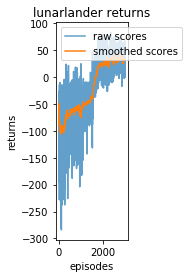

1 {'env name': 'lunarlander', 'policy': Policy(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
), 'returns': array([-64.88290144, -56.79747233, -26.63155144, ...,  46.52169762,
        20.47345464,  71.44895588]), 'lengths': array([ 99,  80, 142, ..., 999, 999, 999])}


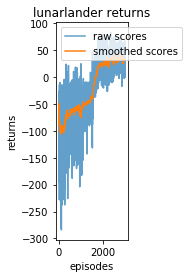

2 {'env name': 'lunarlander', 'policy': Policy(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
), 'returns': array([-64.88290144, -56.79747233, -26.63155144, ...,  46.52169762,
        20.47345464,  71.44895588]), 'lengths': array([ 99,  80, 142, ..., 999, 999, 999])}


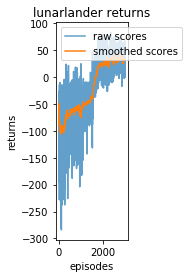

3 {'env name': 'lunarlander', 'policy': Policy(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
), 'returns': array([-64.88290144, -56.79747233, -26.63155144, ...,  46.52169762,
        20.47345464,  71.44895588]), 'lengths': array([ 99,  80, 142, ..., 999, 999, 999])}


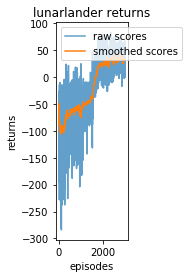

In [79]:

for key, value in enumerate(results):
    returns = value['returns']
    lengths = value['lengths']
    print(key, value)
    plt.subplot(1, 4, key+1)
    plt.plot(returns, alpha=0.7)
    plt.plot(rolling_average(returns, window_size=int(len(returns)/50)))
    plt.legend(['raw scores', 'smoothed scores'], loc="upper left")
    plt.xlabel('episodes')
    plt.ylabel('returns')
    plt.title(value['env name'] + ' returns')
    plt.show()

# plt.figure()
# for key, value in enumerate(results):
#     returns = value['returns']
#     lengths = value['lengths']
#     plt.subplot(4, 1, key+1)
#     plt.plot(lengths, alpha=0.7)
#     plt.plot(rolling_average(lengths, window_size=int(len(lengths)/50)))
#     plt.legend(['raw scores', 'smoothed scores'], loc="upper left")
#     plt.xlabel('episodes')
#     plt.ylabel('lengths')
#     plt.title(value['env name'] + ' lengths')

plt.show()

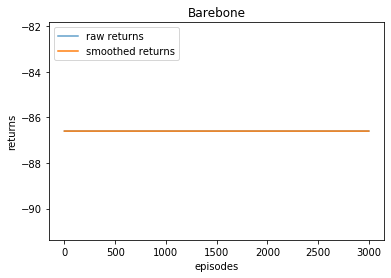

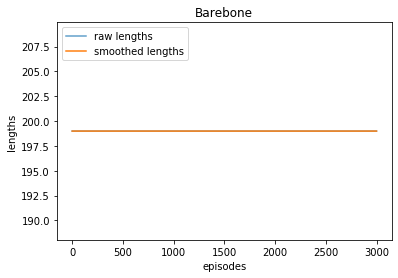

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.title(model)
# plt.show()

plt.figure()
plt.plot(returns, alpha=0.7)
plt.plot(rolling_average(returns, window_size=int(len(returns)/50)))
plt.legend(['raw returns', 'smoothed returns'], loc="upper left")
plt.xlabel('episodes')
plt.ylabel('returns')
plt.title(algorithm)
plt.show()

plt.figure()
plt.plot(lengths, alpha=0.7)
plt.plot(rolling_average(lengths, window_size=int(len(lengths)/50)))
plt.legend(['raw lengths', 'smoothed lengths'], loc="upper left")
plt.xlabel('episodes')
plt.ylabel('lengths')
plt.title(algorithm)
plt.show()

### 5. Watch a Smart Agent!

In [16]:
state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()